In [1]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

Import libraries

In [2]:
import yaml

import torch
from scipy.spatial.distance import directed_hausdorff
import scipy.stats as stats
import numpy as np
from sklearn.utils import resample

from src.lightning import DDPM
from src.datasets import get_dataloader

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
COORDINATES_FOLDER = "trajectories/zinc_difflinker/zinc_final_test/"
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
DATA = config['DATA']
prefix = config['PREFIX']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
NUM_SAMPLES = config['NUM_SAMPLES']
SEED_LIST = [42,1240,14085]

Load model to load the data

In [4]:
model = DDPM.load_from_checkpoint(checkpoint, map_location=device)
model.val_data_prefix = prefix

print(f"Running device: {device}")

if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

/home/mastropietro/anaconda3/envs/diff_explainer/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically

Running device: cuda:1


Load data samples for fragment, linker and anchor indices

In [5]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

#print all fragment masks, linker masks, and anchor masks
for i in range(len(data_list)):
    data_dict[i] = {}
    data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
    data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
    data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)

Read coordinates of generated linkers

In [6]:
for seed in SEED_LIST:
    for i in range(NUM_SAMPLES):
        with open(f"{COORDINATES_FOLDER}final_states_hausdorff_distance_0.5_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/{i}_pred_.xyz", "r") as f:
            num_atoms = int(f.readline().strip())
            f.readline()
            positions = []*num_atoms
            for line in f:
                row = line.strip().split(" ")[1:]
                coords = [float(x) for x in row]
                positions.append(coords)
            dict_key_name = f"positions_{seed}"
            data_dict[i][dict_key_name] = positions

In [7]:
#compute average hausdorff distance over the seeds for each sample
for i in range(NUM_SAMPLES):
    hausdorff_distances = []
    linker_coords_list = []
    for seed in SEED_LIST:
        coords = np.array(data_dict[i][f"positions_{seed}"])
        linker_mask = data_dict[i]["linker_mask"].cpu().numpy().squeeze().astype(bool)
        linker_coords = coords[linker_mask]
        linker_coords_list.append(linker_coords)
    
    # Compute Hausdorff distances for all possible pairs
    for j in range(len(linker_coords_list)):
        for k in range(j+1, len(linker_coords_list)):
            # Compute directed Hausdorff distances in both directions
            h1 = directed_hausdorff(linker_coords_list[j], linker_coords_list[k])[0]
            h2 = directed_hausdorff(linker_coords_list[k], linker_coords_list[j])[0]
            # Hausdorff distance is the maximum of the two directed distances
            hausdorff_distance = max(h1, h2)
            hausdorff_distances.append(hausdorff_distance)
    print("Sample ", i, "Hausdorff distances:", hausdorff_distances) 
    data_dict[i]["average_hausdorff_distance"] = sum(hausdorff_distances)/len(hausdorff_distances)

Sample  0 Hausdorff distances: [0.1220994843273433, 0.21577772602406634, 0.15048911674323082]
Sample  1 Hausdorff distances: [1.8746511011890532, 1.6762880087257326, 2.080253982595029]
Sample  2 Hausdorff distances: [5.4798136055566085, 5.4663335726685816, 1.7950897534624854]
Sample  3 Hausdorff distances: [4.751648864703256, 2.5359211912147925, 3.1654795998632106]
Sample  4 Hausdorff distances: [1.3505729105646374, 1.7072842826089194, 2.2461117855597044]
Sample  5 Hausdorff distances: [5.476472560688496, 4.35110016137201, 3.2773453605853367]
Sample  6 Hausdorff distances: [4.07491676716527, 1.3369100975787807, 4.032417115348113]
Sample  7 Hausdorff distances: [1.5462559288574738, 5.326079440539349, 5.771309438237909]
Sample  8 Hausdorff distances: [1.5223657529267942, 0.08263621040892963, 1.5542307220592864]
Sample  9 Hausdorff distances: [0.3563631900170161, 0.5990050342928968, 0.24667757049774136]
Sample  10 Hausdorff distances: [2.25659061045884, 1.9164770435934477, 1.3494253157080

In [8]:

for i in range(NUM_SAMPLES):
    print(f"Sample {i}: Average Hausdorff distance: {data_dict[i]['average_hausdorff_distance']}")

print("Average Hausdorff distance over all samples: ", sum([data_dict[i]['average_hausdorff_distance'] for i in range(NUM_SAMPLES)])/NUM_SAMPLES)

Sample 0: Average Hausdorff distance: 0.16278877569821348
Sample 1: Average Hausdorff distance: 1.8770643641699383
Sample 2: Average Hausdorff distance: 4.247078977229225
Sample 3: Average Hausdorff distance: 3.4843498852604196
Sample 4: Average Hausdorff distance: 1.7679896595777536
Sample 5: Average Hausdorff distance: 4.368306027548614
Sample 6: Average Hausdorff distance: 3.148081326697388
Sample 7: Average Hausdorff distance: 4.214548269211577
Sample 8: Average Hausdorff distance: 1.0530775617983368
Sample 9: Average Hausdorff distance: 0.4006819316025514
Sample 10: Average Hausdorff distance: 1.8408309899201232
Sample 11: Average Hausdorff distance: 1.0215642144824912
Sample 12: Average Hausdorff distance: 0.03768458124018655
Sample 13: Average Hausdorff distance: 2.318657864633837
Sample 14: Average Hausdorff distance: 0.11324448293374052
Sample 15: Average Hausdorff distance: 0.07083234103922371
Sample 16: Average Hausdorff distance: 0.7883196945470038
Sample 17: Average Hausdo

In [9]:
#print the samples for whihch the average hausdorff distance is less than 1
samples_with_similar_linkers = []
samples_with_different_linkers = []
print("Samples with average Hausdorff distance less than 1:")
for i in range(NUM_SAMPLES):
    if data_dict[i]['average_hausdorff_distance'] < 1:
        samples_with_similar_linkers.append(i)
        print(f"Sample {i}: Average Hausdorff distance: {data_dict[i]['average_hausdorff_distance']}")
    if data_dict[i]['average_hausdorff_distance'] > 3:
        samples_with_different_linkers.append(i)
        print(f"Sample {i}: Average Hausdorff distance: {data_dict[i]['average_hausdorff_distance']}")

Samples with average Hausdorff distance less than 1:
Sample 0: Average Hausdorff distance: 0.16278877569821348
Sample 2: Average Hausdorff distance: 4.247078977229225
Sample 3: Average Hausdorff distance: 3.4843498852604196
Sample 5: Average Hausdorff distance: 4.368306027548614
Sample 6: Average Hausdorff distance: 3.148081326697388
Sample 7: Average Hausdorff distance: 4.214548269211577
Sample 9: Average Hausdorff distance: 0.4006819316025514
Sample 12: Average Hausdorff distance: 0.03768458124018655
Sample 14: Average Hausdorff distance: 0.11324448293374052
Sample 15: Average Hausdorff distance: 0.07083234103922371
Sample 16: Average Hausdorff distance: 0.7883196945470038
Sample 18: Average Hausdorff distance: 0.28279389690453655
Sample 20: Average Hausdorff distance: 0.07147990863759225
Sample 21: Average Hausdorff distance: 0.9010392307402828
Sample 22: Average Hausdorff distance: 3.0377300134266627
Sample 24: Average Hausdorff distance: 0.5241551006294892
Sample 25: Average Hausd

Read Shapley values for similar linkers

In [10]:
#load shapley values
shapley_values_similar_dict = {}
shapley_values_all_dict = {}
shapley_values_different_dict = {}
for i in range(NUM_SAMPLES):
    shapley_values_all_dict[i] = []
    if i in samples_with_similar_linkers:
        shapley_values_similar_dict[i] = []
    if i in samples_with_different_linkers:
        shapley_values_different_dict[i] = []
    for seed in SEED_LIST:
        shapley_values_seed = []
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_hausdorff_distance_0.5_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values_seed.append(float(row[1]))
        shapley_values_all_dict[i].append(shapley_values_seed)
        if i in samples_with_similar_linkers:
            shapley_values_similar_dict[i].append(shapley_values_seed)
        if i in samples_with_different_linkers:
            shapley_values_different_dict[i].append(shapley_values_seed)

Plot Shapley value distribution for similar linkers

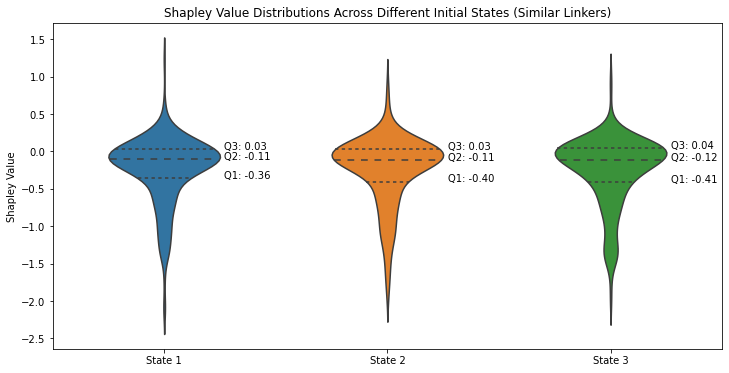

In [11]:
# Prepare data for plotting
shapley_values_all = []
seeds_all = []
samples_all = []

for sample, shapley_values_list in shapley_values_similar_dict.items():
    for seed_index, shapley_values in enumerate(shapley_values_list):
        shapley_values_all.extend(shapley_values)
        seeds_all.extend([SEED_LIST[seed_index]] * len(shapley_values))
        samples_all.extend([sample] * len(shapley_values))

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Shapley Value': shapley_values_all,
    'Seed': seeds_all,
    'Sample': samples_all
})

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Seed', y='Shapley Value', data=plot_data, inner="quartile", scale="width", width=0.5)
plt.title('Shapley Value Distributions Across Different Initial States (Similar Linkers)')
plt.xticks(ticks=[0, 1, 2], labels=["State 1", "State 2", "State 3"])
plt.xlabel(None)

seed_mapping = {seed: idx for idx, seed in enumerate(SEED_LIST)}

# Compute quartiles for each seed
quartiles = plot_data.groupby('Seed')['Shapley Value'].quantile([0.25, 0.5, 0.75]).unstack()

# Print quartiles on the plot
for seed in SEED_LIST:
    q25, q50, q75 = quartiles.loc[seed]
    plt.text(seed_mapping[seed] + 0.27, q25, f'Q1: {q25:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q50, f'Q2: {q50:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q75, f'Q3: {q75:.2f}', color='black', fontsize=10)

plt.savefig(f"results/plots/violin_plot_similar_linkers.png", dpi=300)
plt.savefig(f"results/plots/violin_plot_similar_linkers.pdf", dpi=300)

Plot Shapley value distribution for different the linkers

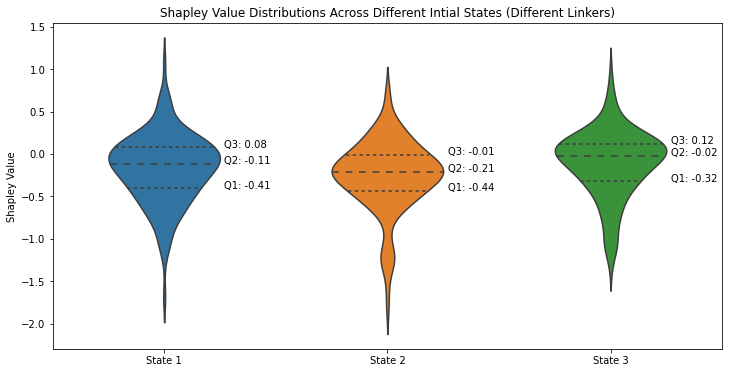

In [12]:
# Prepare data for plotting
#get shapley values for different samples
shapley_values_all = []
seeds_all = []
samples_all = []

for sample, shapley_values_list in shapley_values_different_dict.items():
    for seed_index, shapley_values in enumerate(shapley_values_list):
        shapley_values_all.extend(shapley_values)
        seeds_all.extend([SEED_LIST[seed_index]] * len(shapley_values))
        samples_all.extend([sample] * len(shapley_values))

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Shapley Value': shapley_values_all,
    'Seed': seeds_all,
    'Sample': samples_all
})

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Seed', y='Shapley Value', data=plot_data, inner="quartile", scale="width", width=0.5)
plt.title('Shapley Value Distributions Across Different Intial States (Different Linkers)')
plt.xticks(ticks=[0, 1, 2], labels=["State 1", "State 2", "State 3"])
plt.xlabel(None)

seed_mapping = {seed: idx for idx, seed in enumerate(SEED_LIST)}

# Compute quartiles for each seed
quartiles = plot_data.groupby('Seed')['Shapley Value'].quantile([0.25, 0.5, 0.75]).unstack()

# Print quartiles on the plot
for seed in SEED_LIST:
    q25, q50, q75 = quartiles.loc[seed]
    plt.text(seed_mapping[seed] + 0.27, q25, f'Q1: {q25:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q50, f'Q2: {q50:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q75, f'Q3: {q75:.2f}', color='black', fontsize=10)

plt.savefig(f"results/plots/violin_plot_different_linkers.png", dpi=300)
plt.savefig(f"results/plots/violin_plot_different_linkers.pdf", dpi=300)

Distrubution of Shapley values for all the linkers

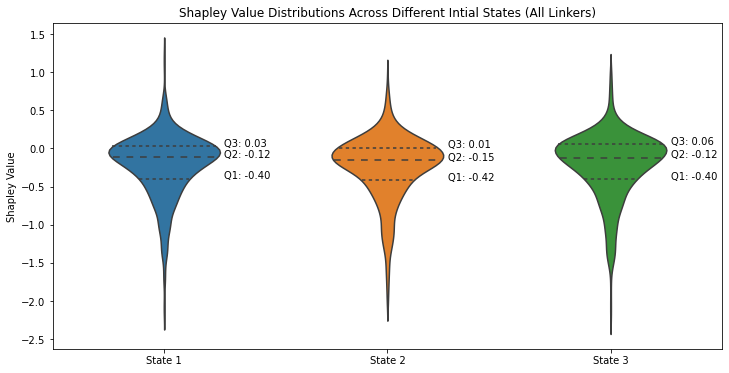

In [13]:
# Prepare data for plotting
#get shapley values for different samples
shapley_values_all = []
seeds_all = []
samples_all = []

for sample, shapley_values_list in shapley_values_all_dict.items():
    for seed_index, shapley_values in enumerate(shapley_values_list):
        shapley_values_all.extend(shapley_values)
        seeds_all.extend([SEED_LIST[seed_index]] * len(shapley_values))
        samples_all.extend([sample] * len(shapley_values))

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Shapley Value': shapley_values_all,
    'Seed': seeds_all,
    'Sample': samples_all
})

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Seed', y='Shapley Value', data=plot_data, inner="quartile", scale="width", width=0.5)
plt.title('Shapley Value Distributions Across Different Intial States (All Linkers)')
plt.xticks(ticks=[0, 1, 2], labels=["State 1", "State 2", "State 3"])
plt.xlabel(None)

seed_mapping = {seed: idx for idx, seed in enumerate(SEED_LIST)}

# Compute quartiles for each seed
quartiles = plot_data.groupby('Seed')['Shapley Value'].quantile([0.25, 0.5, 0.75]).unstack()

# Print quartiles on the plot
for seed in SEED_LIST:
    q25, q50, q75 = quartiles.loc[seed]
    plt.text(seed_mapping[seed] + 0.27, q25, f'Q1: {q25:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q50, f'Q2: {q50:.2f}', color='black', fontsize=10)
    plt.text(seed_mapping[seed] + 0.27, q75, f'Q3: {q75:.2f}', color='black', fontsize=10)

plt.savefig(f"results/plots/violin_plot_all_samples.png", dpi=300)
plt.savefig(f"results/plots/violin_plot_all_samples.pdf", dpi=300)

Inspecting Shapley value Significance

Significance of the Shapley values for all the seeds

In [14]:
# Prepare data for the Kruskal-Wallis H Test
shapley_values_by_seed = [plot_data[plot_data['Seed'] == seed]['Shapley Value'].values for seed in SEED_LIST]

# Perform the Kruskal-Wallis H Test
stat, p_value = stats.kruskal(*shapley_values_by_seed)

print(f'Kruskal-Wallis H test statistic: {stat}')
print(f'p-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There are significant differences in Shapley values across different seeds (reject H0).")
else:
    print("There are no significant differences in Shapley values across different seeds (fail to reject H0).")

Kruskal-Wallis H test statistic: 3.1187405298960584
p-value: 0.2102684429256663
There are no significant differences in Shapley values across different seeds (fail to reject H0).


In [15]:
shapley_values_chosen_seed = plot_data[plot_data['Seed'] == 42]['Shapley Value'].values

Test if Shapley values statistically different from zero

In [16]:

# Check if the data is normally distributed first
shapiro_stat, shapiro_p = stats.shapiro(shapley_values_chosen_seed)
print(f"Shapiro-Wilk test: statistic={shapiro_stat}, p-value={shapiro_p}")

# Choose appropriate test based on normality
alpha = 0.05
if shapiro_p > alpha:  # Data is normally distributed
    # Use one-sample t-test
    t_stat, t_p = stats.ttest_1samp(shapley_values_chosen_seed, 0)
    print(f"One-sample t-test: statistic={t_stat}, p-value={t_p}")
    if t_p < alpha:
        print("The values are significantly different from 0 (not random noise).")
    else:
        print("The values are not significantly different from 0 (could be random).")
else:  
    # Data is not normally distributed - use non-parametric test
    w_stat, w_p = stats.wilcoxon(shapley_values_chosen_seed)
    print(f"Wilcoxon signed-rank test: statistic={w_stat}, p-value={w_p}")
    if w_p < alpha:
        print("The values are significantly different from 0 (not random noise).")
    else:
        print("The values are not significantly different from 0 (could be random).")

Shapiro-Wilk test: statistic=0.9233609437942505, p-value=4.5361585558228074e-17
Wilcoxon signed-rank test: statistic=39995.0, p-value=2.641448828201941e-34
The values are significantly different from 0 (not random noise).


Test against uniform and normal random distribution

In [17]:
# Test against a uniform distribution
ks_uniform_stat, ks_uniform_p = stats.kstest(
    shapley_values_chosen_seed, 
    'uniform', 
    args=(min(shapley_values_chosen_seed), max(shapley_values_chosen_seed)-min(shapley_values_chosen_seed))
)
print(f"Kolmogorov-Smirnov test (uniform): statistic={ks_uniform_stat}, p-value={ks_uniform_p}")
if ks_uniform_p < 0.05:
    print("The values are not uniformly distributed (not random uniform).")
else:
    print("The values appear to be uniformly distributed.")

# Test against a normal distribution
ks_norm_stat, ks_norm_p = stats.kstest(
    (shapley_values_chosen_seed - np.mean(shapley_values_chosen_seed)) / np.std(shapley_values_chosen_seed), 
    'norm'
)
print(f"Kolmogorov-Smirnov test (normal): statistic={ks_norm_stat}, p-value={ks_norm_p}")
if ks_norm_p < 0.05:
    print("The values are not normally distributed (not random normal).")
else:
    print("The values appear to be normally distributed.")

Kolmogorov-Smirnov test (uniform): statistic=0.3161450334416606, p-value=1.0647027811131873e-54
The values are not uniformly distributed (not random uniform).
Kolmogorov-Smirnov test (normal): statistic=0.11931637393978967, p-value=5.0356638453332784e-08
The values are not normally distributed (not random normal).


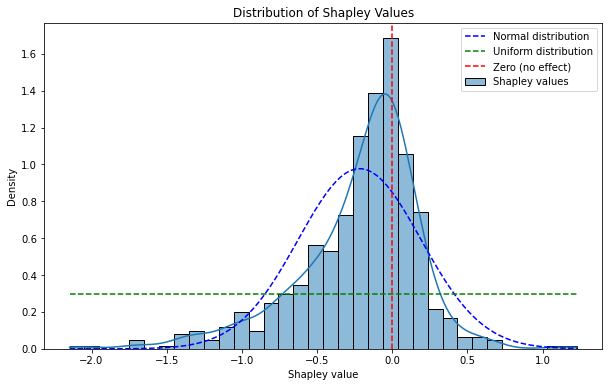

In [18]:
# Calculate mean and standard deviation of the Shapley values
mean_shapley = np.mean(shapley_values_chosen_seed)
std_shapley = np.std(shapley_values_chosen_seed)

# Generate a normal distribution with the same mean and std dev
x = np.linspace(min(shapley_values_chosen_seed), max(shapley_values_chosen_seed), 100)
normal_dist = stats.norm.pdf(x, mean_shapley, std_shapley)

# Generate a uniform distribution with the same range
uniform_dist = stats.uniform.pdf(x, min(shapley_values_chosen_seed), max(shapley_values_chosen_seed) - min(shapley_values_chosen_seed))

plt.figure(figsize=(10, 6))
sns.histplot(shapley_values_chosen_seed, kde=True, stat="density", label='Shapley values')
plt.plot(x, normal_dist, color='blue', linestyle='--', label='Normal distribution')
plt.plot(x, uniform_dist, color='green', linestyle='--', label='Uniform distribution')
plt.axvline(x=0, color='red', linestyle='--', label='Zero (no effect)')
plt.title('Distribution of Shapley Values')
plt.xlabel('Shapley value')
plt.ylabel('Density')
plt.legend()

plt.savefig(f"results/plots/shapley_values_distribution_againts_uniform_normal.png", dpi=300)
plt.savefig(f"results/plots/shapley_values_distribution_againts_uniform_normal.pdf", dpi=300)